In [1]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt

In [2]:
import pandas as pd

# Load the Excel file
file_path = r"D:\fashion_data_2018_2022 (1).xls" # Use the actual file path
df = pd.read_excel(file_path)

# Display the first few rows of the DataFrame
print(df.head())

   product_id    product_name  gender category     pattern  color age_group  \
0        1001    Biker Jacket    Male    Shirt   Geometric  White     25-35   
1        1002  Business Shirt    Male   Jacket  Polka Dots  Beige     18-24   
2        1003     Wool Jacket  Female    Dress   Geometric  Brown     18-24   
3        1004    Summer Dress    Male   Shorts       Plain  White     25-35   
4        1005    Casual Jeans    Male    Shirt       Plain  Beige     35-45   

   season   price   material  sales_count  reviews_count  average_rating  \
0  Spring   70.36  Synthetic           75             65             4.9   
1  Summer   91.59       Wool          296             25             3.5   
2     All  129.52       Wool           50             32             4.3   
3     All  116.01     Cotton          435             73             4.6   
4  Winter  125.48    Viscose           79             36             3.6   

   out_of_stock_times brand  discount last_stock_date  wish_list_cou

In [3]:
# Encode 'season' column

le_season = LabelEncoder()
df['season_code'] = le_season.fit_transform(df['season'])

# Select relevant columns and group by product, year, and month
monthly_sales = df.groupby(['product_name', 'year_of_sale', 'month_of_sale']).agg({
    'sales_count': 'sum',
    'average_rating': 'mean',
    'price': 'mean',
    'season_code': 'first'  # Take the first season_code, assuming it's constant within a month
}).reset_index()

# Display the first few rows of the processed dataset
print(monthly_sales.head())

  product_name  year_of_sale  month_of_sale  sales_count  average_rating  \
0  Beach Shirt          2018              1          424            3.50   
1  Beach Shirt          2018              3           78            3.30   
2  Beach Shirt          2018              4          789            4.20   
3  Beach Shirt          2018              5          445            3.55   
4  Beach Shirt          2018              6          304            4.70   

     price  season_code  
0   97.100            0  
1   95.850            0  
2  104.060            0  
3   78.315            4  
4   43.440            3  


In [4]:
# Scale numerical features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(monthly_sales[['sales_count', 'average_rating', 'price']])

# Create a DataFrame with scaled data
scaled_df = pd.DataFrame(scaled_data, columns=['sales_count', 'average_rating', 'price'])
scaled_df['product_name'] = monthly_sales['product_name']
scaled_df['year_of_sale'] = monthly_sales['year_of_sale']
scaled_df['month_of_sale'] = monthly_sales['month_of_sale']
scaled_df['season_code'] = monthly_sales['season_code']  # Include season_code

# Display the first few rows of the scaled dataset
print(scaled_df.head())


   sales_count  average_rating     price product_name  year_of_sale  \
0     0.278689           0.250  0.592149  Beach Shirt          2018   
1     0.020864           0.150  0.582490  Beach Shirt          2018   
2     0.550671           0.600  0.645932  Beach Shirt          2018   
3     0.294337           0.275  0.446990  Beach Shirt          2018   
4     0.189270           0.850  0.177498  Beach Shirt          2018   

   month_of_sale  season_code  
0              1            0  
1              3            0  
2              4            0  
3              5            4  
4              6            3  


In [5]:
def create_sequences(data, seq_length=12):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = data[i + seq_length, 0]  # Assuming 'sales_count' is the first column
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Split data by product
product_groups = scaled_df.groupby('product_name')

X_train_list = []
y_train_list = []

for name, group in product_groups:
    group = group.sort_values(['year_of_sale', 'month_of_sale'])
    group_data = group[['sales_count', 'average_rating', 'price', 'season_code']].values
    X, y = create_sequences(group_data)
    X_train_list.append(X)
    y_train_list.append(y)

X_train = np.concatenate(X_train_list)
y_train = np.concatenate(y_train_list)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)


X_train shape: (288, 12, 4)
y_train shape: (288,)


In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define LSTM model
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))  # Output layer predicting sales_count

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history=model.fit(X_train, y_train, epochs=500, batch_size=16)

# Save the trained model
model.save('seasonal_sales_model.h5')

Epoch 1/500
18/18 [==============================] - 2s 6ms/step - loss: 0.0603
Epoch 2/500
18/18 [==============================] - 0s 6ms/step - loss: 0.0484
Epoch 3/500
18/18 [==============================] - 0s 6ms/step - loss: 0.0423
Epoch 4/500
18/18 [==============================] - 0s 5ms/step - loss: 0.0418
Epoch 5/500
18/18 [==============================] - 0s 5ms/step - loss: 0.0396
Epoch 6/500
18/18 [==============================] - 0s 5ms/step - loss: 0.0403
Epoch 7/500
18/18 [==============================] - 0s 5ms/step - loss: 0.0383
Epoch 8/500
18/18 [==============================] - 0s 5ms/step - loss: 0.0386
Epoch 9/500
18/18 [==============================] - 0s 5ms/step - loss: 0.0400
Epoch 10/500
18/18 [==============================] - 0s 5ms/step - loss: 0.0415
Epoch 11/500
18/18 [==============================] - 0s 5ms/step - loss: 0.0376
Epoch 12/500
18/18 [==============================] - 0s 5ms/step - loss: 0.0372
Epoch 13/500
18/18 [=================

18/18 [==============================] - 0s 5ms/step - loss: 0.0312
Epoch 103/500
18/18 [==============================] - 0s 5ms/step - loss: 0.0312
Epoch 104/500
18/18 [==============================] - 0s 5ms/step - loss: 0.0337
Epoch 105/500
18/18 [==============================] - 0s 4ms/step - loss: 0.0323
Epoch 106/500
18/18 [==============================] - 0s 4ms/step - loss: 0.0331
Epoch 107/500
18/18 [==============================] - 0s 5ms/step - loss: 0.0327
Epoch 108/500
18/18 [==============================] - 0s 5ms/step - loss: 0.0310
Epoch 109/500
18/18 [==============================] - 0s 5ms/step - loss: 0.0309
Epoch 110/500
18/18 [==============================] - 0s 5ms/step - loss: 0.0306
Epoch 111/500
18/18 [==============================] - 0s 5ms/step - loss: 0.0310
Epoch 112/500
18/18 [==============================] - 0s 5ms/step - loss: 0.0297
Epoch 113/500
18/18 [==============================] - 0s 5ms/step - loss: 0.0301
Epoch 114/500
18/18 [=========

18/18 [==============================] - 0s 6ms/step - loss: 0.0115
Epoch 203/500
18/18 [==============================] - 0s 6ms/step - loss: 0.0118
Epoch 204/500
18/18 [==============================] - 0s 6ms/step - loss: 0.0106
Epoch 205/500
18/18 [==============================] - 0s 6ms/step - loss: 0.0118
Epoch 206/500
18/18 [==============================] - 0s 6ms/step - loss: 0.0108
Epoch 207/500
18/18 [==============================] - 0s 6ms/step - loss: 0.0103
Epoch 208/500
18/18 [==============================] - 0s 6ms/step - loss: 0.0098
Epoch 209/500
18/18 [==============================] - 0s 6ms/step - loss: 0.0105
Epoch 210/500
18/18 [==============================] - 0s 6ms/step - loss: 0.0114
Epoch 211/500
18/18 [==============================] - 0s 6ms/step - loss: 0.0095
Epoch 212/500
18/18 [==============================] - 0s 6ms/step - loss: 0.0103
Epoch 213/500
18/18 [==============================] - 0s 6ms/step - loss: 0.0121
Epoch 214/500
18/18 [=========

18/18 [==============================] - 0s 6ms/step - loss: 0.0026
Epoch 303/500
18/18 [==============================] - 0s 7ms/step - loss: 0.0024
Epoch 304/500
18/18 [==============================] - 0s 7ms/step - loss: 0.0028
Epoch 305/500
18/18 [==============================] - 0s 6ms/step - loss: 0.0025
Epoch 306/500
18/18 [==============================] - 0s 6ms/step - loss: 0.0024
Epoch 307/500
18/18 [==============================] - 0s 6ms/step - loss: 0.0023
Epoch 308/500
18/18 [==============================] - 0s 6ms/step - loss: 0.0023
Epoch 309/500
18/18 [==============================] - 0s 6ms/step - loss: 0.0023
Epoch 310/500
18/18 [==============================] - 0s 6ms/step - loss: 0.0022
Epoch 311/500
18/18 [==============================] - 0s 6ms/step - loss: 0.0023
Epoch 312/500
18/18 [==============================] - 0s 6ms/step - loss: 0.0022
Epoch 313/500
18/18 [==============================] - 0s 6ms/step - loss: 0.0026
Epoch 314/500
18/18 [=========

18/18 [==============================] - 0s 6ms/step - loss: 0.0012
Epoch 403/500
18/18 [==============================] - 0s 6ms/step - loss: 0.0012
Epoch 404/500
18/18 [==============================] - 0s 6ms/step - loss: 0.0011
Epoch 405/500
18/18 [==============================] - 0s 6ms/step - loss: 0.0011
Epoch 406/500
18/18 [==============================] - 0s 6ms/step - loss: 0.0014
Epoch 407/500
18/18 [==============================] - 0s 6ms/step - loss: 0.0013
Epoch 408/500
18/18 [==============================] - 0s 7ms/step - loss: 9.6149e-04
Epoch 409/500
18/18 [==============================] - 0s 6ms/step - loss: 0.0011
Epoch 410/500
18/18 [==============================] - 0s 6ms/step - loss: 0.0012
Epoch 411/500
18/18 [==============================] - 0s 6ms/step - loss: 0.0012
Epoch 412/500
18/18 [==============================] - 0s 6ms/step - loss: 0.0014
Epoch 413/500
18/18 [==============================] - 0s 6ms/step - loss: 9.9246e-04
Epoch 414/500
18/18 [=

18/18 [==============================] - 0s 7ms/step - loss: 8.1405e-04


C:\Users\Pranay kumar\OneDrive\Documents\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               42000     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 42101 (164.46 KB)
Trainable params: 42101 (164.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [8]:
historyP=history

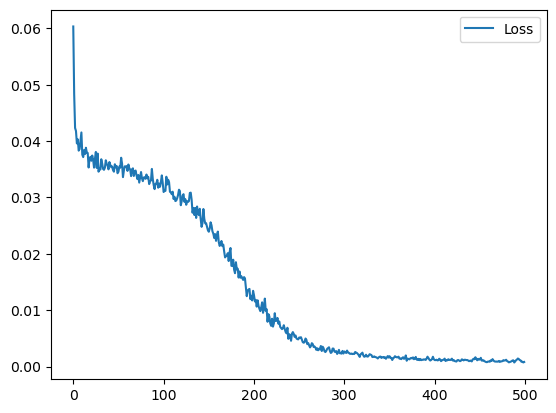

In [9]:
plt.plot(historyP.history['loss'], label='Loss')

plt.legend()

In [10]:
# Load the trained model (if not loaded)
# model = tf.keras.models.load_model('lstm_sales_model.h5')

# Get last 12 months data for prediction in 2023
last_year_data = scaled_df[scaled_df['year_of_sale'] == 2022]
last_year_data = last_year_data.groupby('product_name').tail(12)  # Get last 12 months for each product

future_predictions = []

for name, group in last_year_data.groupby('product_name'):
    group_data = group[['sales_count', 'average_rating', 'price', 'season_code']].values
    group_data = group_data.reshape(1, group_data.shape[0], group_data.shape[1])

    predictions = []
    for i in range(12):
        pred = model.predict(group_data)
        predictions.append(pred[0, 0])

        # Prepare input for the next prediction (update sales_count, keep season_code)
        new_entry = np.array([pred[0, 0], group_data[0, -1, 1], group_data[0, -1, 2], group_data[0, -1, 3]]).reshape(1, 1, 4)
        group_data = np.concatenate((group_data[:, 1:, :], new_entry), axis=1)

    future_predictions.append((name, predictions))

# Convert predictions back to the original scale
predicted_sales_counts = []
for name, preds in future_predictions:
    preds = np.array(preds).reshape(-1, 1)
    dummy_features = np.zeros((len(preds), 2))  # Assuming 2 dummy features for average_rating and price
    scaled_preds = np.concatenate((preds, dummy_features), axis=1)
    
    # Inverse transform with the scaler
    original_scale_preds = scaler.inverse_transform(scaled_preds)
    
    # Extract sales_count predictions
    original_scale_preds = original_scale_preds[:, 0]
    
    # Format and collect predictions
    predicted_sales_counts.extend([(name, month + 1, count) for month, count in enumerate(original_scale_preds)])

# Create DataFrame for predictions
output_df = pd.DataFrame(predicted_sales_counts, columns=['product_name', 'Month', 'Predicted_sales_count'])
output_df['Year'] = 2023

# Print and save predictions to CSV
print(output_df)
output_df.to_csv('predicted_sales_2023_monthly.csv', index=False)


1/1 [==============================] - 0s 17ms/step
    product_name  Month  Predicted_sales_count  Year
0    Beach Shirt      1             241.007008  2023
1    Beach Shirt      2             572.400150  2023
2    Beach Shirt      3              76.106391  2023
3    Beach Shirt      4             191.426957  2023
4    Beach Shirt      5             430.896483  2023
..           ...    ...                    ...   ...
115  Wool Jacket      8             323.028813  2023
116  Wool Jacket      9             375.165045  2023
117  Wool Jacket     10             333.803949  2023
118  Wool Jacket     11             555.208461  2023
119  Wool Jacket     12             520.368184  2023

[120 rows x 4 columns]
